# Preprosesing

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the data
file_path = "/Users/manuel/Documents/GitHub/JeanPierreWeill/ML/sales_2019-01-01_2024_Custumer info.csv"
sales_data = pd.read_csv(file_path)

# 1. Handle Missing Values
sales_data['product_title'].fillna('Unknown', inplace=True)
sales_data['product_type'].fillna('Unknown', inplace=True)

# 2. Encode Categorical Variables
encoder_title = LabelEncoder()
encoder_type = LabelEncoder()
encoder_customer = LabelEncoder()

sales_data['product_title_encoded'] = encoder_title.fit_transform(sales_data['product_title'])
sales_data['product_type_encoded'] = encoder_type.fit_transform(sales_data['product_type'])
sales_data['customer_id_encoded'] = encoder_customer.fit_transform(sales_data['customer_id'].fillna(0).astype(str))

# 3. Aggregate Customer Purchase Patterns
# Example: Counting purchases per customer
customer_purchase_patterns = sales_data.groupby('customer_id_encoded').agg({
    'product_title_encoded': list,
    'product_type_encoded': list
}).reset_index()

# Save the preprocessed data
sales_data.to_csv("/Users/manuel/Documents/GitHub/JeanPierreWeill/ML/preprocessed_sales_data.csv", index=False)
customer_purchase_patterns.to_csv("/Users/manuel/Documents/GitHub/JeanPierreWeill/ML/customer_purchase_patterns.csv", index=False)


/var/folders/4n/_sfxdkln69z0380mkk8642fc0000gn/T/ipykernel_82204/3444082877.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_data['product_title'].fillna('Unknown', inplace=True)
/var/folders/4n/_sfxdkln69z0380mkk8642fc0000gn/T/ipykernel_82204/3444082877.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

#  Feature Engineering Code

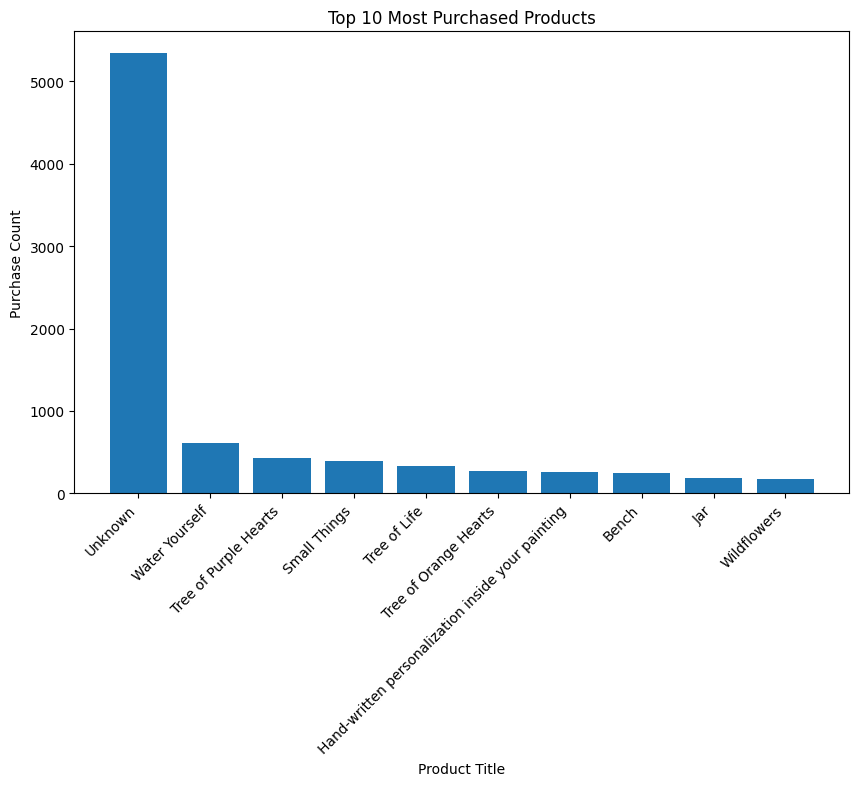

In [1]:
import pandas as pd

# Load the preprocessed data
file_path = "/Users/manuel/Documents/GitHub/JeanPierreWeill/ML/preprocessed_sales_data.csv"
sales_data = pd.read_csv(file_path)

# Ensure data is sorted by customer and order (if applicable)
sales_data.sort_values(by=['customer_id_encoded', 'order_id'], inplace=True)

# 1. Create Sequences of Purchases for Each Customer
# Group by customer and create purchase sequences
customer_purchase_sequences = sales_data.groupby('customer_id_encoded').agg({
    'product_title_encoded': list,
    'product_type_encoded': list
}).reset_index()

# Save the purchase sequences
customer_purchase_sequences.to_csv("/Users/manuel/Documents/GitHub/JeanPierreWeill/ML/customer_purchase_sequences.csv", index=False)

# 2. Calculate Summary Statistics
# Frequency of product purchases
product_purchase_frequency = sales_data.groupby('product_title').size().reset_index(name='purchase_count')

# Save the product frequency data
product_purchase_frequency.to_csv("/Users/manuel/Documents/GitHub/JeanPierreWeill/ML/product_purchase_frequency.csv", index=False)

# Example visualization of most purchased products
import matplotlib.pyplot as plt

# Sort and plot top 10 products
top_products = product_purchase_frequency.sort_values(by='purchase_count', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top_products['product_title'], top_products['purchase_count'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Product Title')
plt.ylabel('Purchase Count')
plt.show()


# Code for Model Training and Evaluation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load the purchase sequences
file_path = "/Users/manuel/Documents/GitHub/JeanPierreWeill/ML/customer_purchase_sequences.csv"
customer_purchase_sequences = pd.read_csv(file_path)

# 1. Prepare the Data for Training
# Flatten sequences for modeling
sequences = customer_purchase_sequences['product_title_encoded'].apply(eval)  # Convert strings to lists
input_sequences = []
output_labels = []

for seq in sequences:
    if len(seq) > 1:
        for i in range(1, len(seq)):
            input_sequences.append(seq[:i])
            output_labels.append(seq[i])

# Pad sequences to uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_sequence_length = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

# Convert outputs to categorical
num_classes = len(np.unique([item for sublist in sequences for item in sublist]))
output_labels = tf.keras.utils.to_categorical(output_labels, num_classes=num_classes)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(input_sequences, output_labels, test_size=0.2, random_state=42)

# 2. Build the RNN Model
model = Sequential([
    Embedding(input_dim=num_classes, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=False),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# 4. Evaluate the Model
results = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {results[1] * 100:.2f}%")

# 5. Predict Next Product for a Sample Sequence
sample_sequence = X_test[0].reshape(1, -1)  # Example test sequence
predicted_probabilities = model.predict(sample_sequence)
predicted_index = np.argmax(predicted_probabilities)

print(f"Predicted Product Title Index: {predicted_index}")


Epoch 1/10


/Users/manuel/Documents/GitHub/JeanPierreWeill/EDA/EDA/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3929 - loss: 3.4576 - val_accuracy: 0.4082 - val_loss: 2.9598
Epoch 2/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.4225 - loss: 2.9016 - val_accuracy: 0.4153 - val_loss: 2.9341
Epoch 3/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.4165 - loss: 2.8784 - val_accuracy: 0.4350 - val_loss: 2.9166
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.4235 - loss: 2.8947 - val_accuracy: 0.4294 - val_loss: 2.9102
Epoch 5/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.4370 - loss: 2.8095 - val_accuracy: 0.4393 - val_loss: 2.8771
Epoch 6/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.4300 - loss: 2.8099 - val_accuracy: 0.4364 - val_loss: 2.8945
Epoch 7/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.4318 - loss: 2.7998 - val_accuracy: 0.4336 - val_loss: 2.8878
Epoch 8/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.4469 - loss: 2.7128 - val_accuracy

# Evaluation Metrics

In [3]:
def precision_at_k(y_true, y_pred, k=5):
    relevant = np.argsort(y_pred, axis=1)[:, -k:]
    matches = [y in relevant[i] for i, y in enumerate(np.argmax(y_true, axis=1))]
    return np.mean(matches)

precision = precision_at_k(y_test, model.predict(X_test), k=5)
print(f"Precision@5: {precision * 100:.2f}%")


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Precision@5: 57.26%


In [4]:
def recall_at_k(y_true, y_pred, k=5):
    relevant = np.argsort(y_pred, axis=1)[:, -k:]
    hits = sum([y in relevant[i] for i, y in enumerate(np.argmax(y_true, axis=1))])
    return hits / len(y_true)

recall = recall_at_k(y_test, model.predict(X_test), k=5)
print(f"Recall@5: {recall * 100:.2f}%")


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Recall@5: 57.26%


# Save the model

In [5]:
from tensorflow.keras.models import Sequential

# Example model for demonstration (use your actual model)
model = Sequential()
model.save("/Users/manuel/Documents/GitHub/JeanPierreWeill/ML/product_recommendation_model.h5")
print("Model saved successfully!")


Model saved successfully!
